In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle

import seaborn as sns
import string
import re
from collections import Counter

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.17.0


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     certificate has expired (_ssl.c:1000)>


In [4]:
# Load data
df_train = pd.read_csv("D:/proj/dataset/tweet_disaster/train.csv")
df_test = pd.read_csv("D:/proj/dataset/tweet_disaster/test.csv")

print(f'Training Set Shape = {df_train.shape}')
print(f'Test Set Shape = {df_test.shape}')

Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


In [5]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

The distribution of tweets that are disaster and not disaster don't seem too unbalanced.

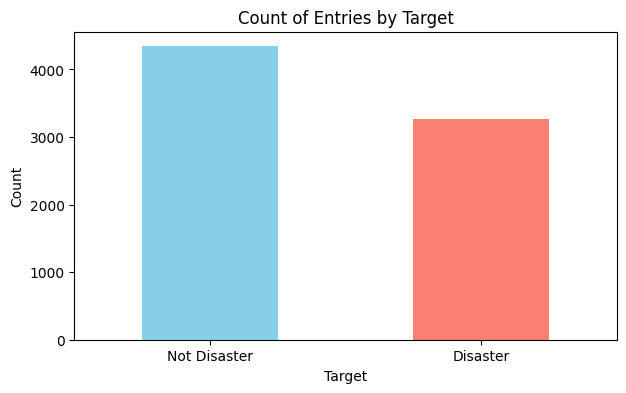

In [7]:
target_counts = df_train['target'].value_counts()

plt.figure(figsize=(7, 4))
target_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Entries by Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'], rotation=0)

plt.show()

The top common keywords are fairly different between the disaster and non-disaster tweets.

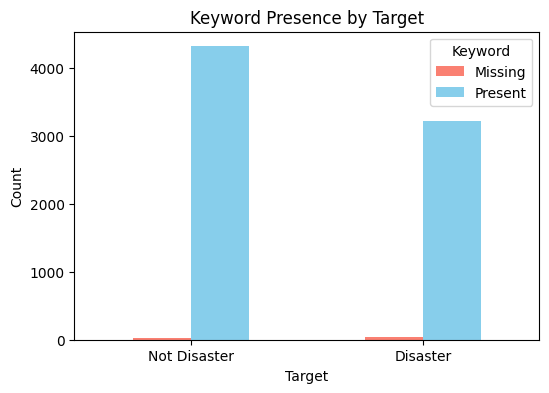

C:\Users\3098333\AppData\Local\Temp\ipykernel_36400\695961645.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Keyword', data=df_top_20_0, palette="Blues_d")


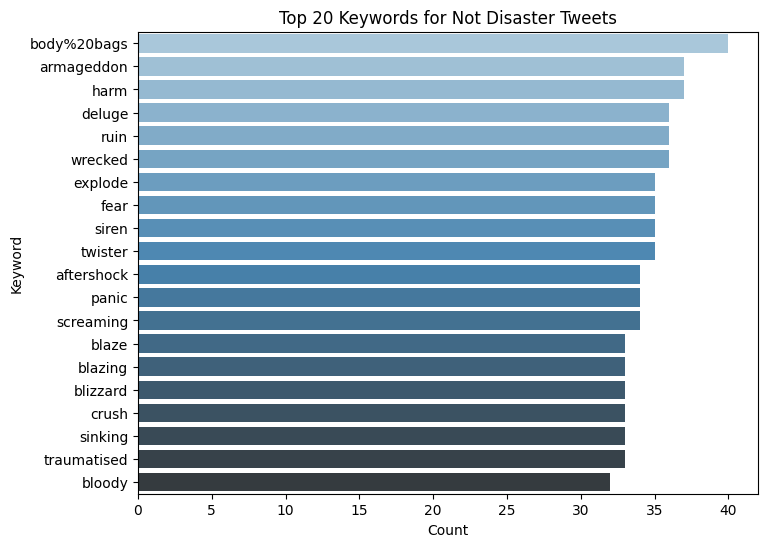

C:\Users\3098333\AppData\Local\Temp\ipykernel_36400\695961645.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Keyword', data=df_top_20_1, palette="Reds_d")


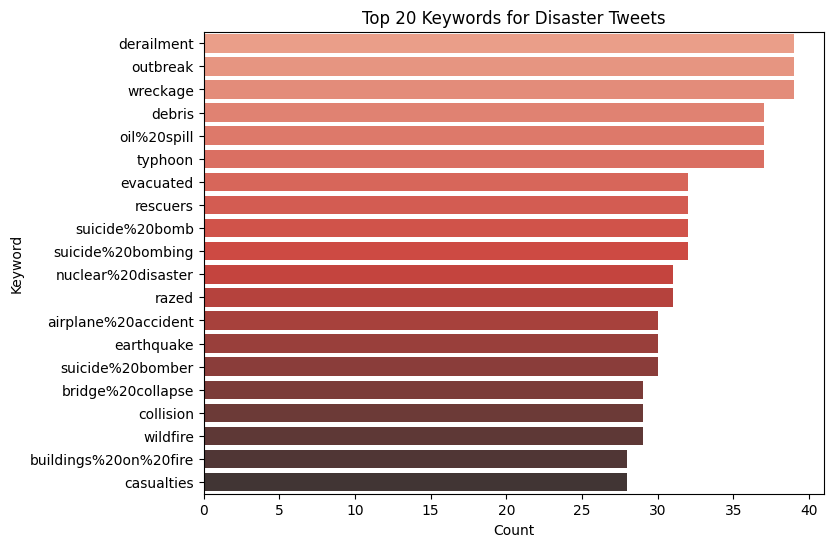

In [8]:
df_train["lowercase_text"] = df_train["text"].str.lower()

df_train['keyword_present'] = df_train['keyword'].apply(lambda x: 'Present' if pd.notnull(x) else 'Missing')

grouped_counts = df_train.groupby(['target', 'keyword_present']).size().unstack()

grouped_counts.plot(kind='bar', figsize=(6, 4), color=['salmon', 'skyblue'])
plt.title('Keyword Presence by Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'], rotation=0)
plt.legend(title='Keyword', loc='upper right')

plt.show()


df_filtered = df_train[df_train['keyword'].notnull()]

keywords_target_0 = df_filtered[df_filtered['target'] == 0]['keyword']
keywords_target_1 = df_filtered[df_filtered['target'] == 1]['keyword']

top_20_keywords_0 = Counter(keywords_target_0).most_common(20)
top_20_keywords_1 = Counter(keywords_target_1).most_common(20)

df_top_20_0 = pd.DataFrame(top_20_keywords_0, columns=['Keyword', 'Count'])
df_top_20_1 = pd.DataFrame(top_20_keywords_1, columns=['Keyword', 'Count'])

plt.figure(figsize=(8, 6))
sns.barplot(x='Count', y='Keyword', data=df_top_20_0, palette="Blues_d")
plt.title('Top 20 Keywords for Not Disaster Tweets')
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(x='Count', y='Keyword', data=df_top_20_1, palette="Reds_d")
plt.title('Top 20 Keywords for Disaster Tweets')
plt.show()

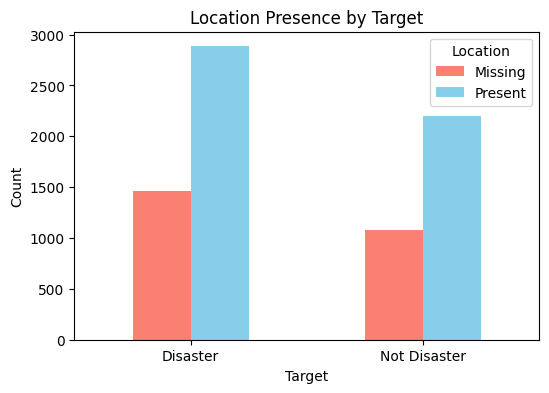

C:\Users\3098333\AppData\Local\Temp\ipykernel_36400\3809575128.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Location', data=df_top_20_0, palette="Blues_d")


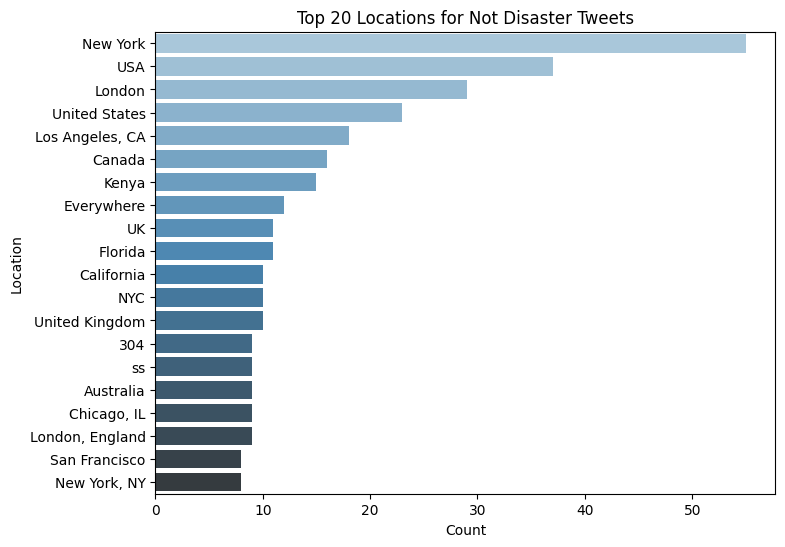

C:\Users\3098333\AppData\Local\Temp\ipykernel_36400\3809575128.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Location', data=df_top_20_1, palette="Reds_d")


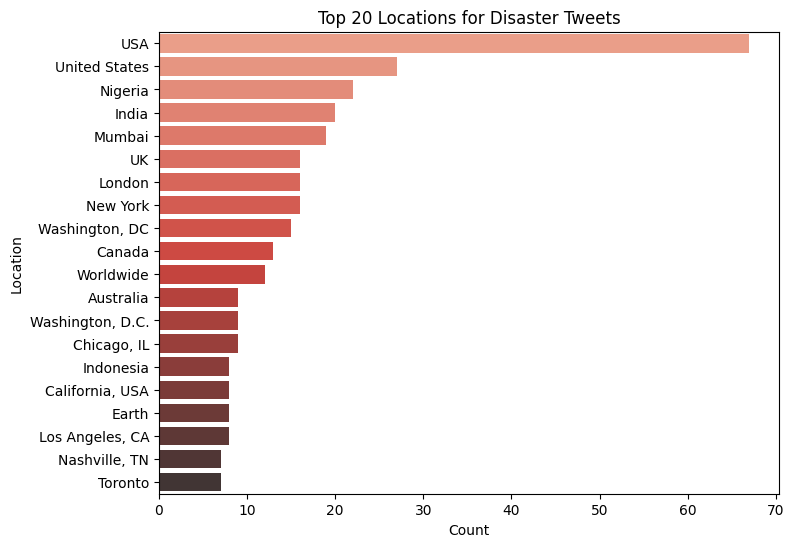

In [9]:
df_train['location_present'] = df_train['location'].apply(lambda x: 'Present' if pd.notnull(x) else 'Missing')

grouped_counts = df_train.groupby(['target', 'location_present']).size().unstack()

grouped_counts.plot(kind='bar', figsize=(6, 4), color=['salmon', 'skyblue'])
plt.title('Location Presence by Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Disaster', 'Not Disaster'], rotation=0)
plt.legend(title='Location', loc='upper right')

plt.show()


df_filtered = df_train[df_train['location'].notnull()]

locations_target_0 = df_filtered[df_filtered['target'] == 0]['location']
locations_target_1 = df_filtered[df_filtered['target'] == 1]['location']

top_20_locations_0 = Counter(locations_target_0).most_common(20)
top_20_locations_1 = Counter(locations_target_1).most_common(20)

df_top_20_0 = pd.DataFrame(top_20_locations_0, columns=['Location', 'Count'])
df_top_20_1 = pd.DataFrame(top_20_locations_1, columns=['Location', 'Count'])

plt.figure(figsize=(8, 6))
sns.barplot(x='Count', y='Location', data=df_top_20_0, palette="Blues_d")
plt.title('Top 20 Locations for Not Disaster Tweets')
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(x='Count', y='Location', data=df_top_20_1, palette="Reds_d")
plt.title('Top 20 Locations for Disaster Tweets')
plt.show()

The distributions for the word count, average word length in both disaster and non-disaster tweets seem to be pretty similar.

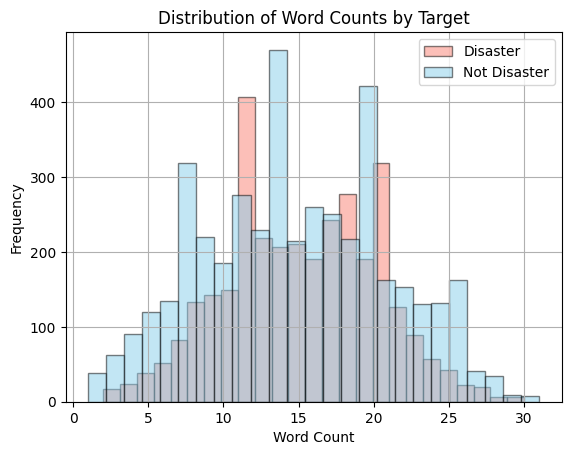

In [10]:
df_train['word_count'] = df_train['lowercase_text'].apply(lambda x: len([word for word in x.split() if word]))

plt.hist(df_train[df_train['target'] == 1]['word_count'], bins=25, alpha=0.5, label='Disaster', color='salmon', edgecolor='black')
plt.hist(df_train[df_train['target'] == 0]['word_count'], bins=25, alpha=0.5, label='Not Disaster', color='skyblue', edgecolor='black')

plt.title('Distribution of Word Counts by Target')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()

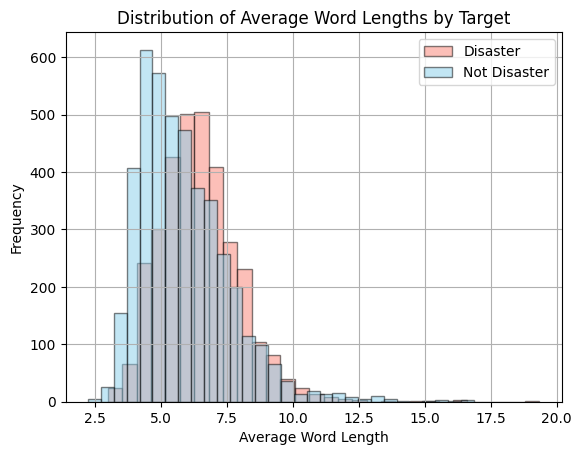

In [11]:
df_train['average_word_length'] = df_train['lowercase_text'].apply(lambda x: (sum(len(s) for s in x.split()) / len(x.split())))

plt.hist(df_train[df_train['target'] == 1]['average_word_length'], bins=30, alpha=0.5, label='Disaster', color='salmon', edgecolor='black')
plt.hist(df_train[df_train['target'] == 0]['average_word_length'], bins=30, alpha=0.5, label='Not Disaster', color='skyblue', edgecolor='black')

plt.title('Distribution of Average Word Lengths by Target')
plt.xlabel('Average Word Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()

the text is the same for both entries, but the target values are different.

In [12]:
duplicate_text = df_train[df_train["text"].duplicated(keep=False)]
unique_targets = duplicate_text.groupby('text').filter(lambda x: x["target"].nunique() != 1)
indices = unique_targets.index.tolist()

# Fix targets for duplicated tweets
df_train.loc[610, 'target'] = 0
df_train.loc[630, 'target'] = 0
df_train.loc[1197, 'target'] = 0
df_train.loc[1221, 'target'] = 0
df_train.loc[1365, 'target'] = 0

df_train.loc[2830, 'target'] = 0
df_train.loc[2831, 'target'] = 0
df_train.loc[2833, 'target'] = 0

df_train.loc[3243, 'target'] = 0
df_train.loc[3248, 'target'] = 0
df_train.loc[3985, 'target'] = 0
df_train.loc[4221, 'target'] = 0
df_train.loc[4232, 'target'] = 0
df_train.loc[4239, 'target'] = 0
df_train.loc[4292, 'target'] = 0
df_train.loc[4305, 'target'] = 0
df_train.loc[4312, 'target'] = 0
df_train.loc[4318, 'target'] = 0
df_train.loc[4320, 'target'] = 0

df_train.loc[4381, 'target'] = 0
df_train.loc[4618, 'target'] = 1
df_train.loc[5620, 'target'] = 0
df_train.loc[6091, 'target'] = 0
df_train.loc[6123, 'target'] = 0
df_train.loc[6616, 'target'] = 0

## Data Preprocessing

In [13]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_punctuation(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

def remove_numbers(text):
    return re.sub(r'[0-9]+', '', text)

def remove_empty_spaces(text):
    words = [word for word in text.split(" ") if (not word.strip() == "")]
    return " ".join(words)

def remove_stopwords(text):
    words = [word for word in text.split(" ") if word not in stop]
    return " ".join(words)

def clean_text(text):
    text = text.lower()
    text = remove_url(text)
    text = remove_html(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = remove_empty_spaces(text)
    text = remove_stopwords(text)
    return text


example = df_train["text"].iloc[0]
print("Before cleaning:", example)
print("After cleaning: ", clean_text(example))

Before cleaning: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
After cleaning:  deeds reason earthquake may allah forgive us


In [14]:
# Data length stats
df_train["length"] = df_train["text"].apply(len)
df_test["length"] = df_test["text"].apply(len)

df_train["cleaned_text"] = df_train["text"].apply(clean_text)
df_test["cleaned_text"] = df_test["text"].apply(clean_text)

X = df_train["cleaned_text"]
y = df_train["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test["cleaned_text"]

Epoch 1/5


c:\Users\3098333\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5606 - loss: 0.6842 - val_accuracy: 0.5883 - val_loss: 0.6597
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6312 - loss: 0.6453 - val_accuracy: 0.7150 - val_loss: 0.5809
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8211 - loss: 0.5022 - val_accuracy: 0.8017 - val_loss: 0.4533
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8815 - loss: 0.3220 - val_accuracy: 0.8004 - val_loss: 0.4316
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9130 - loss: 0.2324 - val_accuracy: 0.7958 - val_loss: 0.4484


Model and tokenizer saved.
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


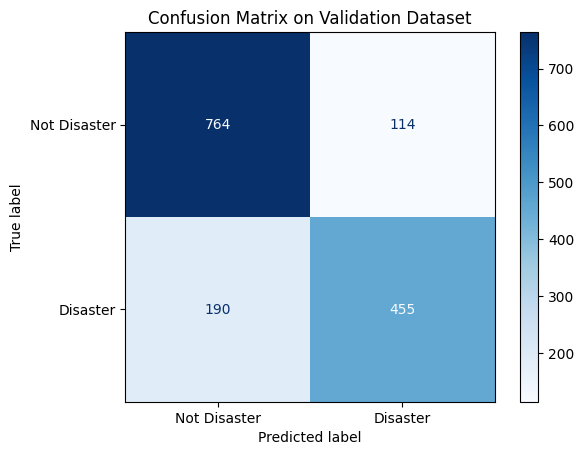

F1 Score: 0.75
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


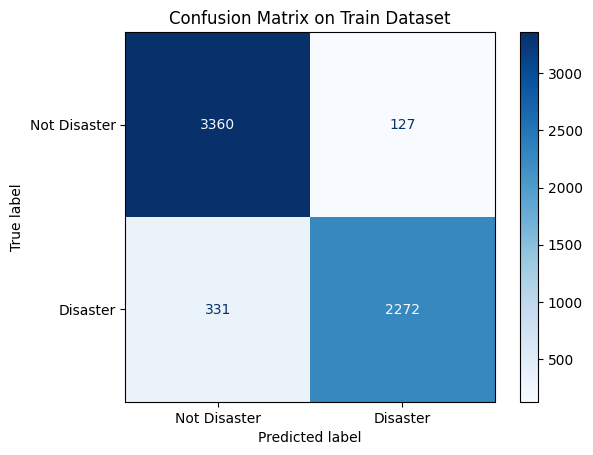

F1 Score: 0.91
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Submission file created: submission.csv


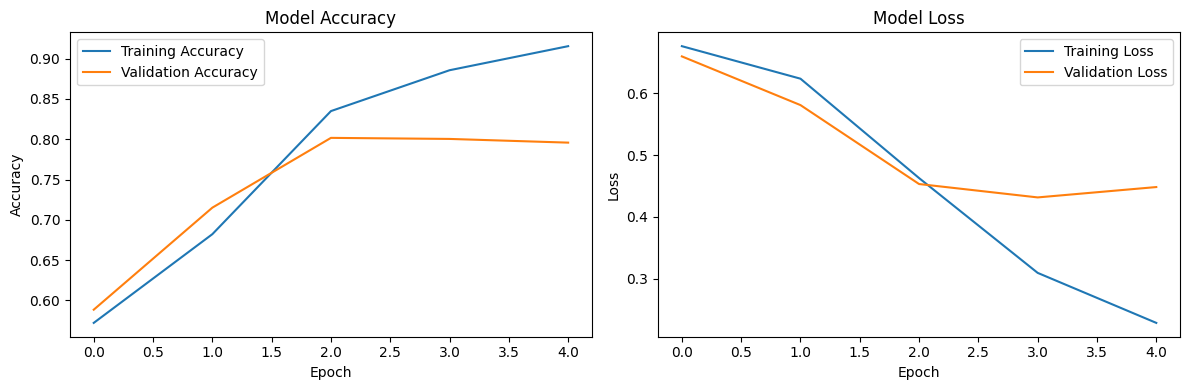

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
{'text': 'There was a major earthquake in the city center.', 'is_disaster': True, 'confidence': 0.9636739492416382}


In [16]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 5
MAX_LEN = 100
EMBEDDING_DIM = 200
MAX_WORDS = 10000


# Tokenize the text
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

# Define the model
def build_model():
    inputs = Input(shape=(MAX_LEN,))
    x = tf.keras.layers.Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN)(inputs)
    x = tf.keras.layers.Conv1D(128, 5, activation='relu')(x)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Build and compile the model
model = build_model()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping]
)

# Save the entire model and tokenizer
model.save('disaster_model.h5')
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model and tokenizer saved.")

# Evaluation function
def evaluate_model(model, X):
    y_pred = model.predict(X)
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()
    return y_pred_classes

# Evaluate on validation set
val_pred = evaluate_model(model, X_val_pad)

# Display confusion matrix
def display_confusion_matrix(y_true, y_pred, dataset):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Disaster", "Disaster"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix on {dataset} Dataset")
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    f1_score = tp / (tp + ((fn + fp) / 2))
    print(f"F1 Score: {f1_score:.2f}")

display_confusion_matrix(y_val, val_pred, "Validation")


# evaluate on train set
train_pred = evaluate_model(model, X_train_pad)
display_confusion_matrix(y_train, train_pred, "Train")

# Make predictions on test set
test_predictions = evaluate_model(model, X_test_pad)

# Create submission file
submission = pd.DataFrame({'id': df_test['id'], 'target': test_predictions})
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Function to make predictions (can be used in your API)
def predict_disaster(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=MAX_LEN)
    prediction = model.predict(padded)[0][0]
    return {"text": text, "is_disaster": bool(prediction > 0.5), "confidence": float(prediction)}

# Example usage
example_text = "There was a major earthquake in the city center."
result = predict_disaster(example_text)
print(result)


## Loading and testing the saved model

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load the saved model
model = tf.keras.models.load_model('disaster_model.h5')

# Load the saved tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Set the MAX_LEN based on the training configuration
MAX_LEN = 100

# Function to make predictions using the loaded model and tokenizer
def predict_disaster(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=MAX_LEN)
    prediction = model.predict(padded)[0][0]
    return {"text": text, "is_disaster": bool(prediction > 0.5), "confidence": float(prediction)}

# Example usage
example_texts = [
    "A major earthquake has destroyed the city center.",
    "The weather is sunny today.",
    "Fire broke out in the forest and killing the animals."
]

for text in example_texts:
    result = predict_disaster(text)
    print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
{'text': 'A major earthquake has destroyed the city center.', 'is_disaster': True, 'confidence': 0.8076449036598206}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
{'text': 'The weather is sunny today.', 'is_disaster': False, 'confidence': 0.35963332653045654}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
{'text': 'Fire broke out in the forest and killing the animals.', 'is_disaster': True, 'confidence': 0.6151924133300781}
